# [Transformer.Trainer](https://huggingface.co/docs/transformers/main_classes/trainer)

## [Trainer - HPO](https://huggingface.co/docs/transformers/ko/hpo_train)
- 🤗 Transformers에서는 🤗 Transformers 모델을 학습시키는데 최적화된 Trainer 클래스를 제공하기 때문에, 사용자는 직접 훈련 루프를 작성할 필요 없이 더욱 간편하게 학습을 시킬 수 있습니다.
- 또한, Trainer는 하이퍼파라미터 탐색을 위한 API를 제공합니다.

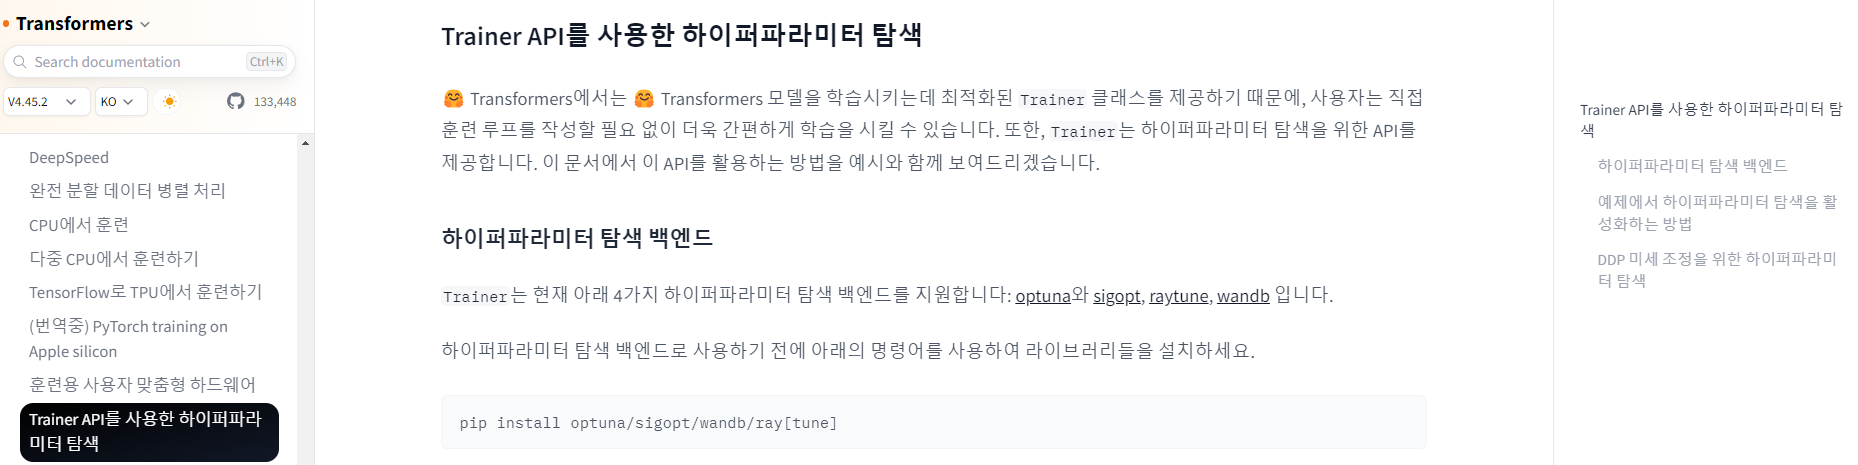

## [Trainer - fine tuning](https://huggingface.co/docs/transformers/ko/training)
- `datasets`: fine tuning을 위한 학습 데이터셋 모듈
- `transformers`: fine tuning을 위한 모듈
- `evaluate`: fine tuning한 모델을 평가하기 위한 모듈

In [ ]:
!pip install datasets transformers evaluate

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.6 MB/s eta 0:00:00


### 데이터셋 로드

#### [glue](https://huggingface.co/datasets/nyu-mll/glue)

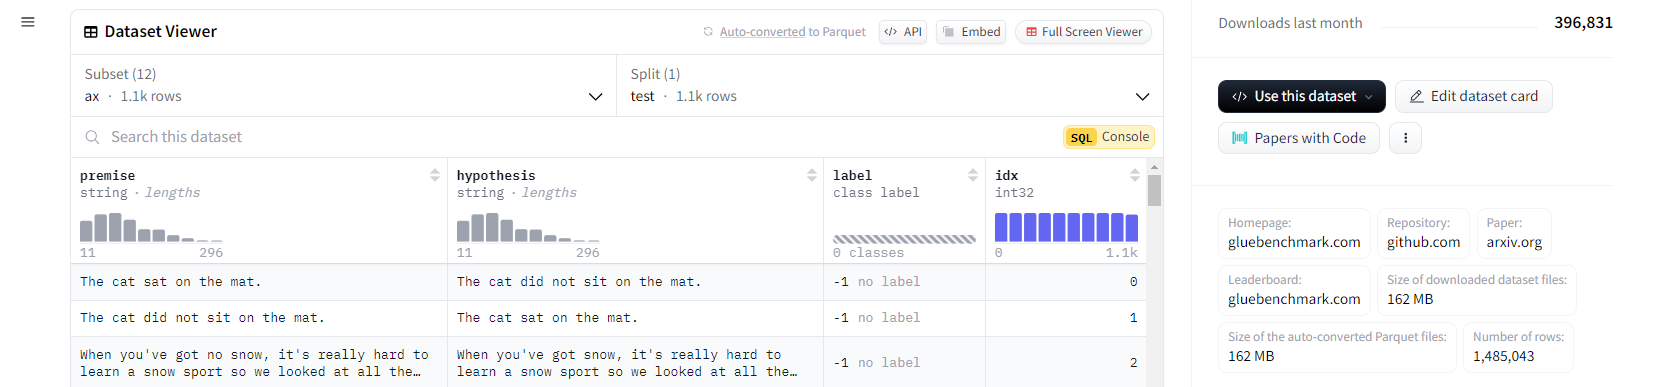

#### [mrpc](https://huggingface.co/datasets/SetFit/mrpc)

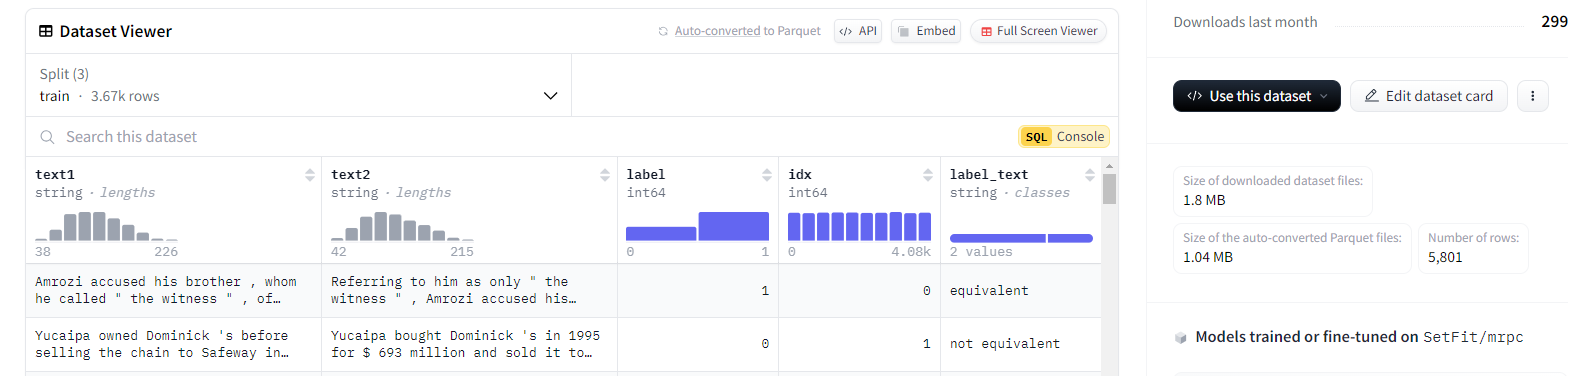

In [ ]:
from datasets import load_dataset

raw_datasets = load_dataset("glue", "mrpc")
raw_datasets

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/649k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/75.7k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/308k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3668 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/408 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1725 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1725
    })
})

- 파이썬의 딕셔너리(dictionary)와 같이 키값으로 raw_datasets 개체의 개별 집합(학습, 검증, 평가)에 접근할 수 있습니다:

In [ ]:
raw_train_dataset = raw_datasets["train"]
raw_train_dataset[0]

{'sentence1': 'Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .',
 'sentence2': 'Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .',
 'label': 1,
 'idx': 0}

- 위의 예에서 보듯이, 레이블(label)이 이미 정수(integers)라서 전처리(preprocessing)가 필요 없습니다.
- 어떤 정수가 어떤 레이블에 해당하는지 파악하기 위해서는 raw_train_dataset의 features 속성을 살펴보면 됩니다.

세부적으로, 레이블(label)은 ClassLabel 타입이고 레이블 이름에 대한 정수 매핑은 names 폴더에 저장되어 있습니다. 0은 not_equivalent를 의미하고, 1은 equivalent를 나타냅니다.

In [ ]:
raw_train_dataset.features

{'sentence1': Value(dtype='string', id=None),
 'sentence2': Value(dtype='string', id=None),
 'label': ClassLabel(names=['not_equivalent', 'equivalent'], id=None),
 'idx': Value(dtype='int32', id=None)}

### 모델 정의
- 두 번째 단계는 모델을 정의하는 것입니다. 두 개의 레이블이 있는 `AutoModelForSequenceClassification` 클래스를 사용합니다.

In [ ]:
from transformers import AutoModelForSequenceClassification

checkpoint = "bert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### [데이터셋 전처리](https://huggingface.co/docs/transformers/ko/preprocessing)

In [ ]:
raw_datasets["train"][0]

{'sentence1': 'Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .',
 'sentence2': 'Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .',
 'label': 1,
 'idx': 0}

In [ ]:
raw_train_dataset.features

{'sentence1': Value(dtype='string', id=None),
 'sentence2': Value(dtype='string', id=None),
 'label': ClassLabel(names=['not_equivalent', 'equivalent'], id=None),
 'idx': Value(dtype='int32', id=None)}

In [ ]:
tokenized_sentences_1 = tokenizer(raw_datasets["train"]["sentence1"])
tokenized_sentences_2 = tokenizer(raw_datasets["train"]["sentence2"])

In [ ]:
tokenized_sentences_1.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
inputs = tokenizer("This is the first sentence.", "This is the second one.")
inputs

{'input_ids': [101, 2023, 2003, 1996, 2034, 6251, 1012, 102, 2023, 2003, 1996, 2117, 2028, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

input_ids 내부의 ID들을 다시 단어로 디코딩하면:

In [ ]:
tokenizer.convert_ids_to_tokens(inputs["input_ids"])

['[CLS]',
 'this',
 'is',
 'the',
 'first',
 'sentence',
 '.',
 '[SEP]',
 'this',
 'is',
 'the',
 'second',
 'one',
 '.',
 '[SEP]']

#### 토크나이저 처리

- 아래 방법은 잘 작동하지만, `input_ids`, `attention_mask`, `token_type_ids` 및 데이터가 담겨진 다차원 리스트가 키로 지정된 `tokenized_dataset` 이라는 별도의 파이썬 딕셔너리를 반환하는 단점이 있습니다.
- 또한 이 방법은 토큰화하는 동안 전체 데이터셋을 저장할 충분한 공간의 `RAM`이 있는 경우에만 작동합니다.

In [ ]:
tokenized_dataset = tokenizer(
    raw_datasets["train"]["sentence1"],
    raw_datasets["train"]["sentence2"],
    padding=True, # 패딩
    truncation=True, # 절단
)

In [ ]:
tokenized_dataset.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

- 특정 데이터를 `dataset` 객체로 유지하기 위해 `Dataset.map()` 메서드를 사용합니다.
- 이 방법은 토큰화(tokenization) 외에 더 많은 전처리가 필요한 경우 유연성을 발휘합니다.
- `map()` 메서드는 데이터셋의 개별 요소에 함수(function)를 적용하여 작동하므로 입력을 토큰화하는 함수를 정의해 보겠습니다:

In [ ]:
def tokenize_function(example):
    return tokenizer(example["sentence1"], example["sentence2"], truncation=True)

In [ ]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1725
    })
})

In [ ]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets

Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1725
    })
})

In [ ]:
tokenized_train = tokenized_datasets['train']

tokenized_train

Dataset({
    features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3668
})

In [ ]:
tokenized_train[0].keys()

dict_keys(['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'])

#### data_collator
- data_collator는 데이터를 batch로 묶어 model에 전달할 수 있는 형태로 만들어주며, DataCollator 클래스의 인스턴스가 되도록 정해져 있다.

DataCollator 클래스는 여러 자식 클래스를 가지는데, 어떤 task를 수행하느냐에 따라 다른 것을 사용하면 된다.

- `DataCollatorWithPadding`: 입력된 시퀀스를 길이가 동일해지도록 패딩하여 batch를 만든다. 텍스트 분류와 같은 작업에 사용한다.
- `DataCollatorForSeq2Seq`: sequence-to-sequence 작업 (e.g. 번역, 요약)을 위한 클래스이다. 이 경우 source와 target sequence를 모두 패딩해준다.
- `DataCollatorForLanguageModeling`: masked language modeling(MLM)과 같이 언어 모델링(language modeling) task에 사용된다.
  - mlm_probability로 토큰을 마스킹할 확률을 지정해줄 수 있다.
- `DataCollatorForTokenClassification`: 토큰 분류 작업 (예: NER)을 위한 배치를 만들어준다.
- `DefaultDataCollator`: 특별한 전처리 없이 데이터를 배치로 묶기만 하는 data collator로, Trainer 클래스의 기본값이다.

In [ ]:
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

0

In [ ]:
tokenizer.pad_token

'[PAD]'

In [ ]:
from transformers import DataCollatorWithPadding

# Model pad token id = Tokenizer Model eos token id
model.config.pad_token_id = tokenizer.pad_token
# Tokenizer Model pad token id = Tokenizer Model eos token id
# tokenizer.pad_token_id = tokenizer.eos_token_id
# tokenizer.pad_token = tokenizer.eos_token

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

- 이 새로운 함수를 테스트하기 위해 학습집합에서 배치(batch)로 묶을 몇개의 샘플들을 가져오겠습니다.
- 여기서는 필요하지도 않을 뿐더러 심지어 문자열까지도 포함하는 idx, sentence1 및 sentence2 열을 제거합니다(문자열로는 텐서를 생성할 수 없습니다).

아래에서 배치(batch) 내의 각 요소들의 길이를 살펴보세요:

In [ ]:
samples = tokenized_datasets["train"][:8]
samples = {k: v for k, v in samples.items() if k not in ["idx", "sentence1", "sentence2"]}
[len(x) for x in samples["input_ids"]]

[50, 59, 47, 67, 59, 50, 62, 32]

- 당연히, 32에서 67까지 다양한 길이의 샘플을 얻을 수 있습니다.
- 동적 패딩(dynamic padding)은 이 배치(batch) 내의 모든 샘플들이 배치 내부에서 최대 길이인 67 길이로 패딩(padding)되어야 함을 의미합니다.
- 동적 패딩(dynamic padding)이 없으면 모든 샘플들은 전체 데이터셋의 최대 길이 또는 모델이 허용할 수 있는 최대 길이로 채워져야 합니다.

data_collator가 동적으로 배치(batch)를 적절하게 패딩(padding)하는지 다시 확인합시다:

In [ ]:
batch = data_collator(samples)
{k: v.shape for k, v in batch.items()}

{'input_ids': torch.Size([8, 67]),
 'token_type_ids': torch.Size([8, 67]),
 'attention_mask': torch.Size([8, 67]),
 'labels': torch.Size([8])}

### [TrainingArguments](https://velog.io/@vantaa89/%ED%97%88%EA%B9%85-%ED%8E%98%EC%9D%B4%EC%8A%A4-Trainer-%EB%AA%A8%EB%93%88-%EC%82%AC%EC%9A%A9%EB%B2%95#trainingarguments)
- Trainer를 정의하기 전에 먼저 수행할 단계는 Trainer가 학습 및 평가에 사용할 모든 하이퍼파라미터(hyperparameters)를 포함하는 TrainingArguments 클래스를 정의하는 것입니다.



- `output_dir`: str: 유일한 required argument로, 훈련된 모델과 체크포인트를 어디에 저장할지를 의미한다. 파일시스템 상의 경로로 지정하거나(e.g. ‘./results’) 허깅페이스 허브에 저장할 repository 이름으로 설정할수도 있다 (e.g. ’bert-uncased-imdb-finetuned’). 후자의 경우 트레이닝 후 trainer.push_to_hub()를 하면 자동으로 허브에 업로드된다.
  - `overwrite_output_dir`: bool: True로 설정시, output_dir에 이미 파일이 존재하는 경우에도 덮어쓰기를 한다.
- `num_train_epochs`: 훈련할 에포크(epoch)의 수이다.
- `per_device_train_batch_size`: train 시의 batch size를 지정해준다.
- `per_device_eval_batch_size`: evaluation 시의 batch size를 지정해준다.
- `learning_rate`: learning rate(학습률)을 지정해준다.
  - `lr_scheduler_type`: learning rate scheduler를 사용하고 싶은 경우 지정해줄 수 있다. default는 당연히 constant이고, linear, cosine, cosine_with_restarts, polynomial, constant_with_warmup 등을 사용할 수 있다.
  - constant가 아닌 LR scheduler를 사용할 시 추가적으로 파라미터를 넣어주어야 한다.
- `weight_decay`: L2 weight decay를 설정한다.
- `logging_strategy`: 로그를 어떻게 남길지 설정한다. 기본값은 steps로, no로 설정하면 로그를 남기지 않으며 epoch로 설정하면 한 에포크가 끝날 때마다, steps로 설정하면 매 logging_steps마다 로그를 남기게 된다.
  - 즉, logging_strategy=‘steps’로 설정시 logging_steps를 같이 설정해주어야 한다. logging_steps는 정수를 넣어줄 수도 있지만 0에서 1 사이의 float 값으로 지정할 수도 있는데, 이 경우 전체 training step에 이를 곱한 값을 사용한다.
- `save_strategy`: 모델 체크포인트를 언제 저장할지 설정한다. 마찬가지로 no, steps, epoch 중 하나를 고를 수 있으며 steps로 설정되면 save_steps를 같이 설정해주어야 한다.
  - `save_total_limit`: 최대로 저장할 수 있는 모델 체크포인트의 수를 지정해준다.
- `evaluation_strategy`: evaluation을 언제 수행할지를 결정한다. 마찬가지로 no, steps, epoch 중 하나를 고를 수 있으며 steps로 설정되면 evaluation_steps를 같이 설정해주어야 한다.
- `use_cpu`: True로 설정할 시 사용가능한 GPU가 있어도 CPU에서 실행한다.
- `seed`: 랜덤 시드를 설정해준다. 많은 경우 42를 사용한다.
- `fp16`: fp16 mixed-precision을 사용할지 여부를 True/False로 설정해준다.
- `disable_tqdm`: False로 설정시, 표 대신 tqdm을 사용해서 progress bar를 표시해준다.
- `load_best_model_at_end`: True로 설정하면 훈련이 끝났을 때 가장 성능이 좋은 모델을 로드해준다.
  - `metric_for_best_model`: 이때 ‘성능이 좋다’는 것의 기준을 무엇으로 삼을지 지정해준다. 후술할 compute_metrics 함수에서 반환하는 metric 중 하나의 이름을 string으로 넣어주면 된다 (e. g. “accuracy”)
  - `greater_is_better`: 해당 metric이 높을 수록 좋은 것인지, 낮을수록 좋은 것인지를 알려준다.

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments("test-trainer")

In [ ]:
training_args

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=False,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=no,
eval_use_gather_object=False,
evaluation_strategy=None,
fp16=

### [Trainer](https://velog.io/@vantaa89/%ED%97%88%EA%B9%85-%ED%8E%98%EC%9D%B4%EC%8A%A4-Trainer-%EB%AA%A8%EB%93%88-%EC%82%AC%EC%9A%A9%EB%B2%95#trainingarguments)
- 모델(model), training_args, 학습집합 및 검증집합, data_collator 및 토크나이저 등, 지금까지 구성된 모든 개체를 전달하여 Trainer를 정의할 수 있습니다

- `model`: transformer 모델 객체나 PyTorch의 nn.Module 객체를 넣어주면 된다.
  - model 대신에, 새로운 모델 객체를 하나 만들어 반환하는 함수인 model_init을 제공해줄 수도 있다.
- `args`: 앞서 소개한 TrainingArguments 객체이다.
- `data_collator`: train/evaluation dataset에 있는 원소들의 list를 묶어서 batch로 만들어주기 위해 사용되는 함수이다. tokenizer를 지정해주지 않은 경우 default_data_collator()가 사용되고, 지정해준 경우는 DataCollatorWithPadding의 인스턴스가 사용된다.
- `train_dataset`: 가장 중요하다고 할 수 있는 훈련용 데이터셋을 지정해준다. transformer의 dataset.Dataset일수도, PyTorch의 Dataset일 수도 있다.
- `eval_dataset`: Evaluation용 데이터셋을 지정해준다. 형식은 train_dataset과 같다.
- `tokenizer`: 데이터를 전처리하기 위한 토크나이저를 지정해준다.
- `compute_metrics`: Evaluation시에 metric들을 계산해주기 위한 함수이다. 함수의 입력과 출력은 특정 형식을 따라야만 하는데, 이는 뒤에서 마저 설명하겠다.
- `optimizers`: 훈련에 사용할 optimizer와 LR scheduler를 지정해준다. torch.optim.Optimizer 객체와 torch.optim.lr_scheduler.LambdaLR 객체의 tuple을 요구한다. 아무것도 입력하지 않으면 AdamW를 사용한다.

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

### fine-tuning(미세 조정)
미세 조정이 시작되고(GPU에서 몇 분 정도 소요됨) 500단계마다 학습 손실(training loss)이 보고됩니다. 그러나 모델의 성능이 좋은지 혹은 나쁜지는 알려주지 않습니다. 그 이유는 다음과 같습니다:
- 학습 과정에서 평가가 수행되도록 `Trainer`에게 `evaluation_strategy` 매개변수를 "steps"(매 eval_steps마다 평가)나 "epoch"(각 epoch 마지막에 평가) 등으로 지정하지 않았습니다.
- 평가 방법 혹은 평가 척도를 정의한 `compute_metrics()` 함수를 `Trainer`에 지정하지 않았습니다. 평가 방법 지정이 안된 상태에서는 평가 과정에서 손실(loss)을 출력했을 것입니다. 직관적인 값은 아니지요.

In [ ]:
trainer.train()

Step,Training Loss
500,0.529600
1000,0.284900


TrainOutput(global_step=1377, training_loss=0.3405499565661949, metrics={'train_runtime': 121.8337, 'train_samples_per_second': 90.32, 'train_steps_per_second': 11.302, 'total_flos': 405114969714960.0, 'train_loss': 0.3405499565661949, 'epoch': 3.0})

### 평가(Evaluation)
- `predict()` 메서드의 출력은 3개의 필드(`predictions`, `label_ids` 및 `metrics`)가 있는 또 다른 네임드튜플(named tuple)입니다.
- `metrics` 필드에는 전달된 데이터셋의 손실(loss)과 시간 메트릭(time metrics) 값만 포함됩니다. 시간 메트릭(time metrics)은 예측에 걸린 전체 및 평균 시간을 나타냅니다.

In [ ]:
predictions = trainer.predict(tokenized_datasets["validation"])
print(predictions.predictions.shape, predictions.label_ids.shape)

(408, 2) (408,)


- 보시다시피 `predictions`은 모양이 408 x 2인 2차원 배열입니다.
- 408은 우리가 예측에 사용한 데이터셋의 요소 개수입니다. 이는 우리가 `predict()`에 전달한 데이터셋의 각 요소에 대한 `로짓(logit)`값들입니다.
- 이 로짓(logit)값들을 레이블과 비교할 수 있는 예측 결과로 변환하려면 두 번째 축(second axis)에 존재하는 항목에서 최대값이 있는 인덱스를 가져와야 합니다:

In [ ]:
import numpy as np

preds = np.argmax(predictions.predictions, axis=-1)

In [ ]:
preds

array([1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,

In [ ]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

In [ ]:
metric.compute(predictions=preds, references=predictions.label_ids)

{'accuracy': 0.8553921568627451}

### compute_metrics() 생성

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    predictions, label_ids = eval_pred.predictions, eval_pred.label_ids
    predictions = predictions.argmax(axis=1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=label_ids)
    f1 = f1_metric.compute(predictions=predictions, references=label_ids, average="weighted")
    return {
        "accuracy": accuracy["accuracy"],
        "f1": f1["f1"]
    }

- `evaluation_strategy` 매개변수가 "epoch"으로 설정되고 새로운 TrainingArguments와 모델을 생성합니다.
  - 그렇지 않으면 이미 앞에서 학습된(fine-tuned) 모델의 학습을 계속해서 수행할 것입니다. 새로운 학습 실행을 시작하기 위해 다음을 실행합니다.
- 각 에포크(epoch)가 끝날 때 메트릭(metrics)을 출력하도록 하기 위해서, `compute_metrics()` 함수를 사용하여 새 Trainer를 정의하는 방법을 아래 코드에서 보여주고 있습니다.

In [ ]:
training_args = TrainingArguments("test-trainer", evaluation_strategy="epoch")

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
training_args = TrainingArguments(
	output_dir='./results',
	evaluation_strategy="epoch",
	num_train_epochs=3,
	per_device_train_batch_size=16,
	per_device_eval_batch_size=32,
	learning_rate=3e-5,
	logging_strategy="epoch",
	load_best_model_at_end=True,
	save_strategy="epoch",
	# metric_for_best_model의 default값 loss
	metric_for_best_model="accuracy", # 위에서 정의한 compute_metrics()의 return 값을 작성
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

trainer = Trainer(
    model,
    training_args, # args -> 정의된 평가지료 학습진행
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, # 위에서 정의한 함수 추가
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
result = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.554900,0.427280,0.813725,0.807434
2,0.331600,0.381663,0.850490,0.845203
3,0.185300,0.469998,0.855392,0.849324


In [ ]:
result

TrainOutput(global_step=690, training_loss=0.35726392441901605, metrics={'train_runtime': 99.3831, 'train_samples_per_second': 110.723, 'train_steps_per_second': 6.943, 'total_flos': 428577075854640.0, 'train_loss': 0.35726392441901605, 'epoch': 3.0})

# 모델 배포

## [ONNX](https://huggingface.co/docs/transformers/main/ko/trainer)
-  Transformers 모델을 제품 환경에서 배포하기 위해서는 모델을 직렬화된 형식으로 내보내고 특정 런타임과 하드웨어에서 로드하고 실행할 수 있으면 유용합니다.
- 🤗 Optimum은 Transformers의 확장으로, PyTorch 또는 TensorFlow에서 모델을 ONNX와 TFLite와 같은 직렬화된 형식으로 내보낼 수 있도록 하는 exporters 모듈을 통해 제공됩니다.
- 🤗 Optimum은 또한 성능 최적화 도구 세트를 제공하여 특정 하드웨어에서 모델을 훈련하고 실행할 때 최대 효율성을 달성할 수 있습니다.

## [TFLite](https://huggingface.co/docs/transformers/main/ko/tflite)

## [TorchScript](https://huggingface.co/docs/transformers/main/ko/torchscript)

# 재미있는 예제들
- https://metamath1.github.io/blog/posts/gentle-t5-trans/gentle_t5_trans.html
- https://youngchannel.co.kr/aistudy/T5-%ED%8C%8C%EC%9D%B8%ED%8A%9C%EB%8B%9D%EC%9C%BC%EB%A1%9C-%EC%B9%9C%EA%B7%BC%ED%95%9C-%EB%8C%80%ED%99%94%ED%98%95-%EC%B1%97%EB%B4%87-%EB%A7%8C%EB%93%A4%EA%B8%B0
- https://seungbeomdo.tistory.com/79
- https://wikidocs.net/166803